In [1]:
from datetime import datetime
from operator import add
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql.functions import avg, format_number, round
from pyspark.sql.types import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import re

conf = SparkConf()

conf.setMaster("spark://192.168.2.173:7077") \
        .setAppName("olle-analysis")\
        .set("spark.dynamicAllocation.enabled", True)\
        .set("spark.shuffle.service.enabled", True)\
        .set("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .set("spark.executor.cores",2)\
        .set("spark.cores.max",4)\
        .set("spark.driver.port",9998)\
        .set("spark.blockManager.port",10005)

context = SparkContext(conf=conf)
context.getOrCreate()

<SparkContext master=spark://192.168.2.173:7077 appName=olle-analysis>

In [2]:
filepath_mt = "hdfs://192.168.2.173:9000/user/ubuntu/mean_temp_preprocessed/*.txt"
filepath_st = "hdfs://192.168.2.173:9000/user/ubuntu/stations_preprocessed.txt"

### Preprocess the mean temperature and weather stations data

In [3]:
spark = SparkSession(context)

# Load all the weather stations as a Spark dataframe
df_st0 = spark.read.format("csv")\
                                .option("header", "true")\
                                .load(filepath_st)
df_st1 = df_st0.select([F.col(col).alias(col.strip()) for col in df_st0.columns]).drop("STANAME", "LAT", "LON", "HGHT")

# Load all the mean temperature data as a Spark dataframe
df_mt0 = spark.read.format("csv")\
                                .option("header", "true")\
                                .load(filepath_mt)
df_mt1 = df_mt0.select([F.col(col).alias(col.strip()) for col in df_mt0.columns]).drop("SOUID", "Q_TG")

# Fetch the header names of both dataframes
header_mt = df_mt1.schema.names
header_st = df_st1.schema.names

In [4]:
# Convert null values, typed as "-9999", as None in the dataframe.
df_mt2 = df_mt1.withColumn("TG", 
                            when(col('TG') == -9999, None)\
                            .otherwise(col('TG')))

# Multiply every data point (mean temperature) with 0.1,
# since each value is mutliplied with a factor 10 in 
# the original text files.
df_mt2 = df_mt2\
                 .withColumn("TG", format_number(0.1*(df_mt2['TG']), 2)\
                 .cast(DoubleType()))    

# Convert the weather station IDs to integers.
df_mt2 = df_mt2\
                 .withColumn("STAID", df_mt2['STAID']\
                 .cast(IntegerType()))

df_st2 = df_st1\
                 .withColumn("STAID", df_st1['STAID']\
                 .cast(IntegerType()))

In [5]:
print("The schema of the mean temperature dataframe:")
df_mt2.printSchema()

print("The column names and their data types:")
for col_name, dtype in df_mt2.dtypes:
    print(f" • {col_name} {dtype}")
    
print(("\nPS. The date is kept as a string type, since it was\n")+
      ("easier to run queries to find duplicates of the ")+
      ("same dates."))

The schema of the mean temperature dataframe:
root
 |-- STAID: integer (nullable = true)
 |-- DATE: string (nullable = true)
 |-- TG: double (nullable = true)

The column names and their data types:
 • STAID int
 • DATE string
 • TG double

PS. The date is kept as a string type, since it was
easier to run queries to find duplicates of the same dates.


In [6]:
print("The schema of the stations dataframe:")
df_st2.printSchema()

print("The column names and their data types:")
for col_name, dtype in df_st2.dtypes:
    print(f" • {col_name} {dtype}")

The schema of the stations dataframe:
root
 |-- STAID: integer (nullable = true)
 |-- CN: string (nullable = true)

The column names and their data types:
 • STAID int
 • CN string


In [7]:
# Add the country label for each weather station in the
# mean temperature dataframe
df_mt3 = df_mt2.alias("mt")\
                           .join(df_st2.alias("st"), 
                            on = col("mt.STAID") == col("st.STAID"),
                            how = "inner")\
                           .select(col("mt.DATE"), col("st.CN"), col("mt.TG"))

In [8]:
# Take the mean temperature (of the mean temperature) for all
# weather stations in each country each day.
df_mt4 = df_mt3.groupBy(col("DATE"), col("CN"))\
                                    .agg(format_number(F.mean('TG'),2)\
                                    .alias("TG_mean"))

### Time series analysis of the data

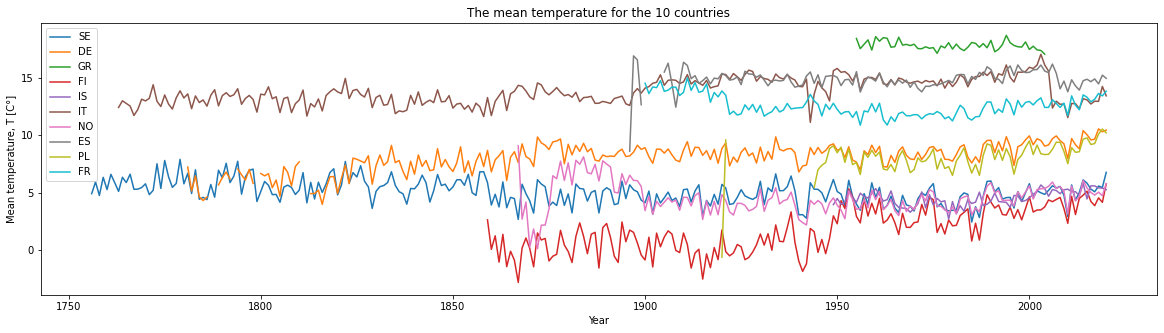

In [9]:
# The chosen countries are: Sweden, Germany, Greece, Finland, Iceland
# Italy, Norway, Spain, Poland and France.
countries= ['SE', 'DE', 'GR', 'FI','IS', 'IT', 'NO', 'ES', 'PL','FR']

# Define the figure
plt.rcParams["figure.figsize"] = (20,5)
plt.figure()
for i in range(len(countries)):
    # Fetch the country
    df0= df_mt4.select("*").distinct().where(col("CN") == countries[i])
    
    # Convert the dates to years and add it as a column in the dataframe
    df1= df0.withColumn("year", df0.DATE.substr(1,4))
    
    # Transform the Pandas dataframe to a Spark dataframe
    df2 = df1.select(*['DATE', 'TG_mean', 'CN', 'year']).toPandas()
    
    # Define the data types for each column
    df3 = df2.astype({'DATE' : 'datetime64', 'CN' : 'string', 'TG_mean' : 'float64', 'year' : 'int64'})
    
    # Take the moving average of the (mean temperature) for each year
    df4 = df3.groupby(['year'],as_index=False).mean('TG_mean')
    
    # Remove the current year
    df5 = df4[df4.year != 2021]

    # Visualize the moving average of the mean temperature for all
    # the countries
    plt.plot(df5['year'], df5['TG_mean'], label = i)
    plt.xlabel("Year")
    plt.ylabel("Mean temperature, T̅ [C°]")
plt.legend(countries)
plt.title("The mean temperature for the 10 countries")
plt.show()

### Stop the application

In [12]:
context.stop()